In [1]:
# This script is used to first run the model with the previously trained parameters, to then apply the model on a specific period

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 3, Finished, Available, Finished)

In [2]:
# Function to make sure the script autostops, in case of wrong lakehouse destination

def lakehouse_gatekeep(expected_db = "ml_curate_lakehouse"):
    db = spark.catalog.currentDatabase()

    if db != expected_db:
       raise Exception(
        f"Forkert Lakehouse er tilkoblet som default: '{db}'."
        f"Det rigtige lakehouse er: '{expected_db}'. Sæt default lakehouse til '{expected_db}' i Explorer i venstre side."
        )
    else:
        print(f"Det korrekte lakehouse: '{db}' er valgt. scriptet fortsættes")

lakehouse_gatekeep()

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 4, Finished, Available, Finished)

Det korrekte lakehouse: 'ml_curate_lakehouse' er valgt. scriptet fortsættes


In [2]:
# Imports, dependencies etc.


!pip install imbalanced-learn
!pip install category_encoders
!pip install shap



    # Imports

import joblib
import shutil

from datetime import datetime
import traceback

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import get_scorer_names
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import category_encoders as ce
import shap
from imblearn import over_sampling
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score
from sklearn.tree import plot_tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession
from sklearn.utils.class_weight import compute_sample_weight


import mlflow

mlflow.autolog(disable = True)

StatementMeta(, d60a48c9-e53c-4189-923d-2ebe307d1036, 4, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 29.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 58.0 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nni 3.0 requires filelock<3.12, but you have filelock 3.13.1 which 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:

solutions_ml = spark.read.format("delta").load("cantshow")
solutions_ml = solutions_ml.toPandas()

# Lakehouse import/export automatically changed categorical variable to object types, therefore: 


for col in solutions_ml.select_dtypes(include = 'object').columns:
    solutions_ml[col] = solutions_ml[col].astype('category')

solutions_ml['Is_EOQ'] = solutions_ml['Is_EOQ'].astype('category') 
solutions_ml['Quarter'] = solutions_ml['Quarter'].astype('category') 
solutions_ml['YearName'] = solutions_ml['YearName'].astype('category') 


X = solutions_ml.drop(columns=['OpportunityState',
'OpportunityStatusGroup',
'OpportunityNumber',
'CloseDate',
'IndustryName',
'OpportunitySalesTeam',
'AnnualContractValueDKK',
'MarginValueDKK',
'YearName'
#'Title',
#'Site', 
#'Department'
#'OpportunityState_num'
])

y = solutions_ml[['OpportunityState']]

opp_id = solutions_ml[['OpportunityNumber']]

closed_needed_later = solutions_ml[['YearName', 'CloseDate']]



## Mapper won: 1 & lost: 0

le = LabelEncoder()

y = le.fit_transform(y)

y = pd.Series(y)


X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.3,
    stratify = y,
    random_state = 123
)


StatementMeta(, d60a48c9-e53c-4189-923d-2ebe307d1036, 5, Finished, Available, Finished)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [5]:
solutions_ml.dtypes

solutions_ml['CloseDate'].min()

StatementMeta(, d60a48c9-e53c-4189-923d-2ebe307d1036, 7, Finished, Available, Finished)

Timestamp('2018-08-21 00:00:00')

In [5]:



## Mapper won: 1 & lost: 0

le = LabelEncoder()

y = le.fit_transform(y)

y = pd.Series(y)


X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.3,
    stratify = y,
    random_state = 123
)

weights = compute_sample_weight(class_weight = "balanced", y = y_train)


sales_xgb = XGBClassifier(
    n_estimators=400,
    learning_rate= 0.1788,
    max_depth = 5,
    min_child_weight = 2,
    reg_alpha=1,
    reg_lambda=10,
    subsample=1,
    colsample_bytree=0.5,
    colsample_by_level = 1,
    colsample_bynode = 0.5,
    gamma = 0.3,
    enable_categorical=True,
    use_label_encoder=False,
    objective = "binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state = 1234)

sales_xgb.fit(X_train, y_train,
    eval_set = [(X_test, y_test)],
    verbose = False,
    sample_weight = weights)


StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 7, Finished, Available, Finished)

[21:46:01] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/learner.cc:742: 
Parameters: { "colsample_by_level" } are not used.



,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,0.5
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'logloss'


In [6]:
solutions_ml.dtypes

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 8, Finished, Available, Finished)

OpportunityStatusGroup             category
OpportunityNumber                  category
OpportunityState                   category
TotalContractValueDKK               float64
AnnualContractValueDKK              float64
MarginValueDKK                      float64
MonthName                          category
YearName                           category
CloseDate                    datetime64[us]
EmployeeName                       category
OpportunityConsciaCountry          category
OpportunitySalesTeam               category
DaysBetweenCreateClose                int32
SubType                            category
DealSizeName                       category
IndustryName                       category
TechnologyName                     category
TCV_Margin_Ratio                    float64
Quarter                            category
Is_EOQ                             category
sum_3m_won                          float64
sum_12m_won                         float64
emp_lag_1m_won                  

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 9, Finished, Available, Finished)

Træningsdata:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75      1099
           1       0.90      0.79      0.84      2081

    accuracy                           0.81      3180
   macro avg       0.79      0.81      0.79      3180
weighted avg       0.82      0.81      0.81      3180

Testdata:
               precision    recall  f1-score   support

           0       0.60      0.73      0.66       471
           1       0.84      0.74      0.79       892

    accuracy                           0.74      1363
   macro avg       0.72      0.74      0.72      1363
weighted avg       0.76      0.74      0.74      1363

    Importance                    Feature
4     0.223869     DaysBetweenCreateClose
2     0.105563               EmployeeName
10    0.066842                     Is_EOQ
7     0.060569             TechnologyName
5     0.055826                    SubType
3     0.055274  OpportunityConsciaCountry
8     0.050048           T

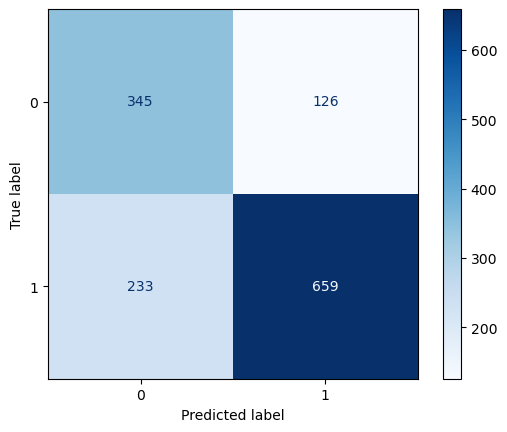

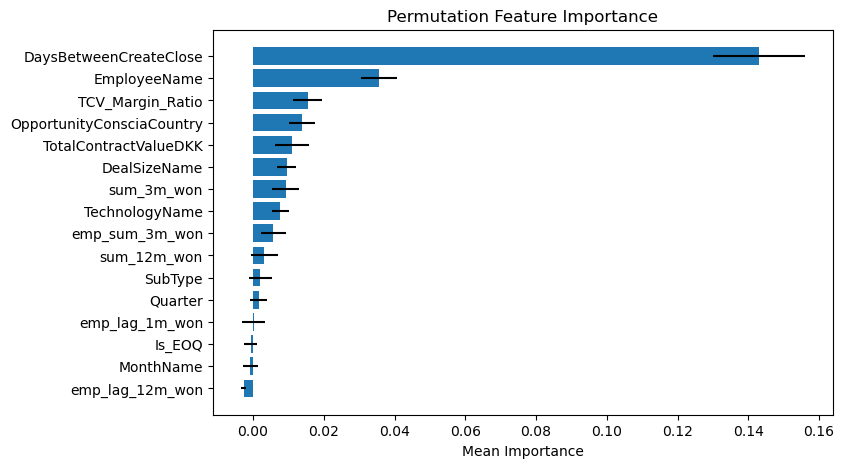

In [ ]:
#### XGBoost ####

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd


y_train_proba = sales_xgb.predict_proba(X_train)[:, 1]
y_test_proba  = sales_xgb.predict_proba(X_test)[:, 1]

threshold = 0.5
y_train_pred = (y_train_proba >= threshold).astype(int)
y_test_pred  = (y_test_proba  >= threshold).astype(int)

print("Træningsdata:\n", classification_report(y_train, y_train_pred))
print("Testdata:\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')



model_featureimportance = sales_xgb.feature_importances_

grid_fe = pd.DataFrame({
    "Importance": model_featureimportance,
    "Feature": X_train.columns
}).sort_values("Importance", ascending=False)

print(grid_fe)



perm_imp_grid = permutation_importance(
    sales_xgb,
    X_test,
    y_test,
    n_repeats=10,
    random_state=123
)

perm_imp_grid_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_imp_grid.importances_mean,
    'Std': perm_imp_grid.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(
    perm_imp_grid_df['Feature'],
    perm_imp_grid_df['Importance'],
    xerr=perm_imp_grid_df['Std']
)
plt.gca().invert_yaxis()
plt.title('Permutation Feature Importance')
plt.xlabel('Mean Importance')
plt.show()


In [ ]:
Active_opportunities = spark.read.format("delta").load("cantshow")
Active_opportunities = Active_opportunities.toPandas()

for col in Active_opportunities.select_dtypes(include = 'object').columns:
    Active_opportunities[col] = Active_opportunities[col].astype('category')


Active_opportunities['Is_EOQ'] = Active_opportunities['Is_EOQ'].astype('category') 
Active_opportunities['Quarter'] = Active_opportunities['Quarter'].astype('category') 
Active_opportunities['YearName'] = Active_opportunities['YearName'].astype('category') 


# Making sure DaysBetweenCreateClose is createdate - estimatedclosedate instead of createdate - today for active opprtunities
    # In case salespeople havent paid attention to the estimated close date (its in the past), the original value persists.

import pandas as pd

Active_opportunities['CloseDate'] = pd.to_datetime(Active_opportunities['CloseDate'])
Active_opportunities['DaysBetweenCreateToday'] = Active_opportunities['DaysBetweenCreateClose']

today = pd.Timestamp.today().normalize()

future_estimate = (
    Active_opportunities['DaysBetweenCreateClose']
    + (Active_opportunities['CloseDate'] - today).dt.days
)

# Replace only where CloseDate is in the future
Active_opportunities.loc[
    Active_opportunities['CloseDate'] >= today,
    'DaysBetweenCreateClose'
] = future_estimate

Active_needed_later = Active_opportunities[['YearName', 'CloseDate']]


Active_opp_x = Active_opportunities.drop(columns=[
'OpportunityStatusGroup',
'OpportunityNumber',
'CloseDate',
'IndustryName',
'OpportunitySalesTeam',
'AnnualContractValueDKK',
'MarginValueDKK',
'YearName',
'DaysBetweenCreateToday',
'OpportunityState'
])




Active_opp_id = Active_opportunities[["OpportunityNumber"]]
Active_opp_y = Active_opportunities[["OpportunityState"]]

Active_opp_x["Prediction"] = sales_xgb.predict_proba(Active_opp_x)[:, 1]
Active_opp_x["Classification"] = (Active_opp_x["Prediction"] >= 0.5).astype(int)

active_opp = pd.concat([Active_opp_id, Active_opp_y, Active_opp_x, Active_needed_later], axis=1)

##

X['Prediction'] = sales_xgb.predict_proba(X)[:, 1]
X['Classification'] = (X['Prediction'] >= 0.5).astype(int)

closed_opp = pd.concat([opp_id, y, X, closed_needed_later], ignore_index = False, axis = 1)


## 

                            ### ----- ### Figure out something smarter here

active_opp['Status'] = 'Open'
closed_opp['Status'] = 'Closed'


closed_opp = closed_opp.rename(columns={0: "OpportunityState"})

# Remap values: 1 → 'Won', 0 → 'Lost'
closed_opp["OpportunityState"] = closed_opp["OpportunityState"].map({1: "Won", 0: "Lost"})

total_opportunities = pd.concat([closed_opp, active_opp], ignore_index=True, axis = 0)



StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 10, Finished, Available, Finished)

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1153 1185 1329 ...  947 3063 1779]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


In [9]:
Active_opportunities.dtypes

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 11, Finished, Available, Finished)

OpportunityStatusGroup             category
OpportunityNumber                  category
OpportunityState                   category
TotalContractValueDKK               float64
AnnualContractValueDKK              float64
MarginValueDKK                      float64
MonthName                          category
YearName                           category
EmployeeName                       category
OpportunityConsciaCountry          category
OpportunitySalesTeam               category
DaysBetweenCreateClose                int64
SubType                            category
DealSizeName                       category
IndustryName                       category
TechnologyName                     category
CloseDate                    datetime64[us]
TCV_Margin_Ratio                    float64
Quarter                            category
Is_EOQ                             category
sum_3m_won                          float64
sum_12m_won                         float64
emp_lag_1m_won                  

In [10]:
test = Active_opportunities[[
    'OpportunityNumber', 'DaysBetweenCreateClose', 'DaysBetweenCreateToday', 'CloseDate'
]]

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 12, Finished, Available, Finished)

In [11]:
402712.9, 387175.9, 351229.9, 332012.9, 336120.7, 393550.4, 345422.9, 311976.1, 347876.4, 328937.7, 333129.8, 343623.8

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 13, Finished, Available, Finished)

(402712.9,
 387175.9,
 351229.9,
 332012.9,
 336120.7,
 393550.4,
 345422.9,
 311976.1,
 347876.4,
 328937.7,
 333129.8,
 343623.8)

In [13]:
# saving validation metrics to push them into lakehouse



# Precision, recall, F1
clas_rep_dict_train = classification_report(y_train, y_train_pred, output_dict = True)
clas_rep_dict_test = classification_report(y_test, y_test_pred, output_dict = True)
report_train_df = pd.DataFrame(clas_rep_dict_train).transpose().reset_index()
report_test_df = pd.DataFrame(clas_rep_dict_test).transpose().reset_index()

# model_feature_importance

#feature_imp_xgb = pd.DataFrame({
#    "Feature": X.columns,
#    "Importance": model_featureimportance
#})



StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 15, Finished, Available, Finished)

In [15]:
test = total_opportunities[total_opportunities['OpportunityState'] == "Open"]

StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 17, Finished, Available, Finished)

,OpportunityNumber,OpportunityState,TotalContractValueDKK,MonthName,EmployeeName,OpportunityConsciaCountry,DaysBetweenCreateClose,SubType,DealSizeName,TechnologyName,...,sum_3m_won,sum_12m_won,emp_lag_1m_won,emp_lag_12m_won,emp_sum_3m_won,Prediction,Classification,YearName,CloseDate,Status
4543,OP0009346,Open,4589.648316,December,Not Available,Conscia United Kingdom,1153,Hardware & Software,< 50.000,Other,...,268.0,627.0,-1.0,-1.0,-1.0,0.226052,0,2025,2027-06-15,Open
4544,OP0009347,Open,558323.523648,December,Not Available,Conscia United Kingdom,1185,Hardware & Software,250.000 - 650.000,Other,...,268.0,627.0,-1.0,-1.0,-1.0,0.183650,0,2025,2027-07-01,Open
4545,OP0009348,Open,12374.010000,December,Not Available,Conscia United Kingdom,1329,Hardware & Software,< 50.000,Other,...,268.0,627.0,-1.0,-1.0,-1.0,0.194662,0,2025,2027-09-11,Open
4546,OP0009349,Open,22189.074732,December,Not Available,Conscia United Kingdom,1209,Hardware & Software,< 50.000,Other,...,268.0,627.0,-1.0,-1.0,-1.0,0.191290,0,2025,2027-07-13,Open
4547,OP0009350,Open,85515.161688,December,Not Available,Conscia United Kingdom,445,Hardware & Software,50.000 - 100.000,Other,...,268.0,627.0,-1.0,-1.0,-1.0,0.171907,0,2025,2026-06-26,Open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837,OP0007790,Open,0.000000,November,Not Available,Conscia United Kingdom,1373,Hardware & Software,< 50.000,Other,...,144.0,514.0,-1.0,-1.0,-1.0,0.175848,0,2025,2027-02-28,Open
5838,OP0007804,Open,0.000000,November,Not Available,Conscia United Kingdom,2165,Hardware & Software,< 50.000,Other,...,144.0,514.0,-1.0,-1.0,-1.0,0.175848,0,2025,2028-03-31,Open
5839,OP0007805,Open,0.000000,November,Not Available,Conscia United Kingdom,947,Hardware & Software,< 50.000,Other,...,144.0,514.0,-1.0,-1.0,-1.0,0.175848,0,2025,2026-07-31,Open
5840,OP0007807,Open,0.000000,November,Not Available,Conscia United Kingdom,3063,Hardware & Software,< 50.000,Other,...,144.0,514.0,-1.0,-1.0,-1.0,0.175848,0,2025,2029-06-23,Open


In [18]:
## Pushing to lakehouse

spark = SparkSession.builder.getOrCreate()


# Active and closed tasks, both separated and combined

spark.createDataFrame(active_opp).write.format("delta").mode("overwrite").saveAsTable("active_opp_with_predict")
spark.createDataFrame(closed_opp).write.format("delta").mode("overwrite").saveAsTable("closed_opp_with_predict")
spark.createDataFrame(total_opportunities).write.format("delta").mode("overwrite").saveAsTable("total_opportunities")

# Model metric export including:
    # - Model confidence, Confusion Matrix, Feature importances
        # The metrics not getting pushed are natively producable with measures in PBI, further reducing the models load

#PFI
spark.createDataFrame(perm_imp_grid_df).write.format("delta").mode("overwrite").saveAsTable("sales_perm_imp")
#MI
spark.createDataFrame(grid_fe).write.format("delta").mode("overwrite").saveAsTable("sales_MI")
# Precision, recall, F1

spark.createDataFrame(report_train_df).write.format("delta").mode("overwrite").saveAsTable("sales_pres_recall_train")
spark.createDataFrame(report_test_df).write.format("delta").mode("overwrite").saveAsTable("sales_pres_recall_test")

# Budget

spark.createDataFrame(Budget).write.format("delta").mode("overwrite").saveAsTable('sales_budget')



StatementMeta(, 1f14b609-23d5-4bd4-abbd-ac1580c56011, 20, Finished, Available, Finished)